# Practical 1

The main aim of this practical is for you to automate the Bayesian assimilation loop for the single pendulum system that 
was discussed within lecture 1. Having done this, you will reconstruct the system's dynamics over the observation period. 
In doing all this, you will be able to vary the number and accuracy of the observations, and also vary the prior on the 
initial condition. In this manner, you can investigate the sensitivity of the results of the assimilation problem to 
these parameters. 

First we import the necessary libraries:

In [1]:
# Import the necessary libraries for this notebook, 
# installing pygeoinf if required. 
try:
    from pygeoinf import data_assimilation as da
except ImportError: 
    %pip install pygeoinf --quiet
    from pygeoinf import data_assimilation as da

import numpy as np
import matplotlib.pyplot as plt
from pygeoinf.data_assimilation.pendulum import single

The code block below sets up the assimilation problem and generates synthetic data for us to use. The code below 
will just run, but later you can modify it, changing various parameters such as the number of observations. 

Generating synthetic data...


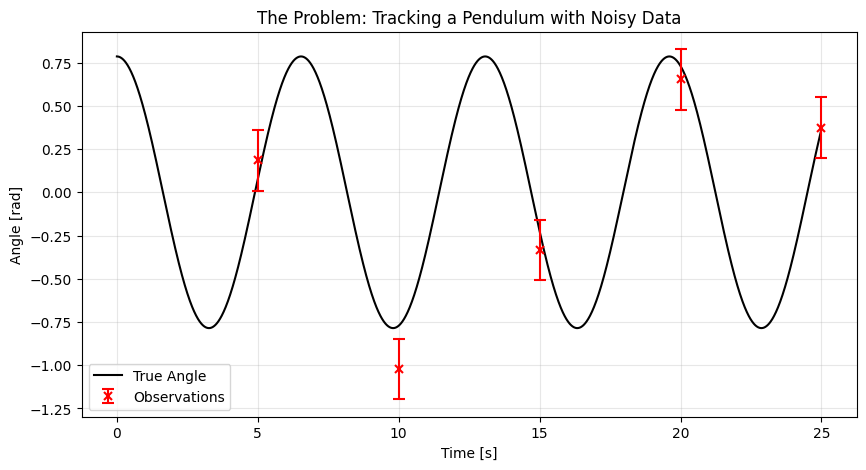

In [2]:
# Initial Condition
# TODO -- vary the initial conditions
true_y0 = np.array([np.deg2rad(45), 0.0])

# Create the Assimilation Problem Manager
# We use this class to manage the "Truth" and generate data.
problem = da.BayesianAssimilationProblem(eom_func=single.physics.eom)

# Define Observations
# TODO -- vary the number and spacing of the observations
n_obs = 5
dt_obs = 5

t_obs_points = np.linspace(
    dt_obs,
    dt_obs*n_obs, 
    n_obs
)

# TODO -- vary the observational error. Note 
#         that this error need not be the same 
#         for all observations
obs_error_sigma = np.deg2rad(5.0) 
R = np.array([[obs_error_sigma**2]])

# Observation Operator for theta
H = np.array([[1.0, 0.0]])

# Register these observations with the problem
print("Generating synthetic data...")
for t in t_obs_points:
    problem.add_observation(
        time=t, covariance=R, operator=H, value=None  
    )

# 5. Generate the "Truth" and the Noisy Data
truth_data = problem.generate_synthetic_data(
    true_initial_condition=true_y0,
    dt_render=0.01    
)

# Visualise the Problem
t_true = truth_data["t_ground_truth"]
y_true = truth_data["state_ground_truth"]
obs_list = problem.observations  # List of (time, model) tuples

plt.figure(figsize=(10, 5))
plt.plot(t_true, y_true[0], "k-", label="True Angle")

# Extract observation values for plotting
t_vals = [t for t, _ in obs_list]
y_vals = [m.y_obs[0] for _, m in obs_list]

plt.errorbar(
    t_vals, y_vals, 
    yerr=2*obs_error_sigma, 
    fmt='rx', 
    capsize=4,             
    elinewidth=1.5,        
    markeredgewidth=1.5,   
    label='Observations'
)

plt.xlabel("Time [s]")
plt.ylabel("Angle [rad]")
plt.title("The Problem: Tracking a Pendulum with Noisy Data")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## Part 1 - Implementing the assimilation loop

In [3]:
# Set the bounds for the probability grid
# TODO -- the size or resolution of the grid can be varied. 
bounds = [(-np.pi, np.pi), (-5, 5)]
resolution = [300,300]

# Set the prior on the initial conditions
# TODO -- this choice can be varied
prior_mean = [0.0, 0.0]
prior_cov = np.diag([0.5**2, 0.5**2])

prior_pdf = da.get_gaussian_pdf(prior_mean, prior_cov)
initial_prior_grid = da.ProbabilityGrid.from_bounds(
    bounds, 
    resolution, 
    prior_pdf
)


# --- Step C: The Loop (TODO) ---

# initialise some variables
current_grid = initial_prior_grid
manual_history = []
t_current = 0.0

# Loop through the raw observation times and values
for t_obs, y_observed in zip(t_vals, y_vals):
    
    # 1. Calculate time step to the next observation
    dt = t_obs - t_current

    # Reset variables to None at the start of each iteration
    # This ensures we don't accidentally reuse values from the previous loop
    forecast_grid = None
    analysis_grid = None
    evidence = None
    
    # ============================================================
    # TODO: YOUR CODE HERE
    # ============================================================
    

    # --- TODO TASK 1: FORECAST (The Prior for this step) ---
    # Evolve 'current_grid' forward by dt to create the 'forecast_grid'.
    # Hint: Use current_grid.push_forward(...). You will need to provide
    # the dynamic rule for the system which is stored in 'problem.eom_func'
    
    # forecast_grid = ...


    # --- TODO TASK 2: OBSERVE (The Likelihood) ---
    #  A. Create a LinearGaussianLikelihood object associated with 
    #     the current observation. 
    
    # lik_model = da.LinearGaussianLikelihood(...)

    # B. Evaluate this likelihood on the forecast_grid to get 'lik_grid'.
    
    # lik_grid = ...


    # --- TODO TASK 3: ANALYSIS (Bayes' Theorem) ---
    # We want: Posterior = (Prior * Likelihood) / Evidence
    
    # A. Calculate the unnormalised posterior (Numerator)
    # Hint: ProbabilityGrid supports element-wise multiplication using '*'
    
    # unnorm_posterior = ...
    
    
    # B. Calculate the Evidence (Denominator)
    # This is the total probability mass (integral) of the unnormalised grid.
    # Hint: ProbabilityGrid has a property 'total_mass' that returns the 
    #       necessary integral approximated using quadrature
    
    # evidence = ...
    
    
    # C. Calculate the Final Posterior (Normalisation)
    # Divide the unnormalised grid by the evidence.
    
    # analysis_grid = ...
   

    # ============================================================
    # END YOUR CODE
    # ============================================================
    
    
    # Safety mock: If variables are still None use the current_grid
    # so the script doesn't crash.
    if forecast_grid is None: forecast_grid = current_grid
    if analysis_grid is None: analysis_grid = current_grid
    if evidence is None: evidence = 1.0
    

    # Store result for plotting
    manual_history.append({
        'time': t_obs,
        'forecast': forecast_grid,
        'analysis': analysis_grid,
        'evidence': evidence
    })
    
    # Update state for next iteration
    current_grid = analysis_grid
    t_current = t_obs
    print(f"Assimilated y={y_observed:.2f} at t={t_obs:.2f}")

Assimilated y=0.18 at t=5.00
Assimilated y=-1.02 at t=10.00
Assimilated y=-0.33 at t=15.00
Assimilated y=0.65 at t=20.00
Assimilated y=0.37 at t=25.00


The code block below plots the posterior at the final observation time you have determined, and compares it to the result 
that is automated within the `BayesianAssimilationProblem` class through its method `run`. If your implmentation 
is correct, the two PDFs should look identical. 

Once the two PDFs agreee, you can go back and vary the observations and priors within the problem to qualitatively assess their
impact. A particularly important question is the dependence on the initial prior. You might see whether with sufficiently many 
observations the choice of initial prior becomes immaterial. 


Running automated verification...


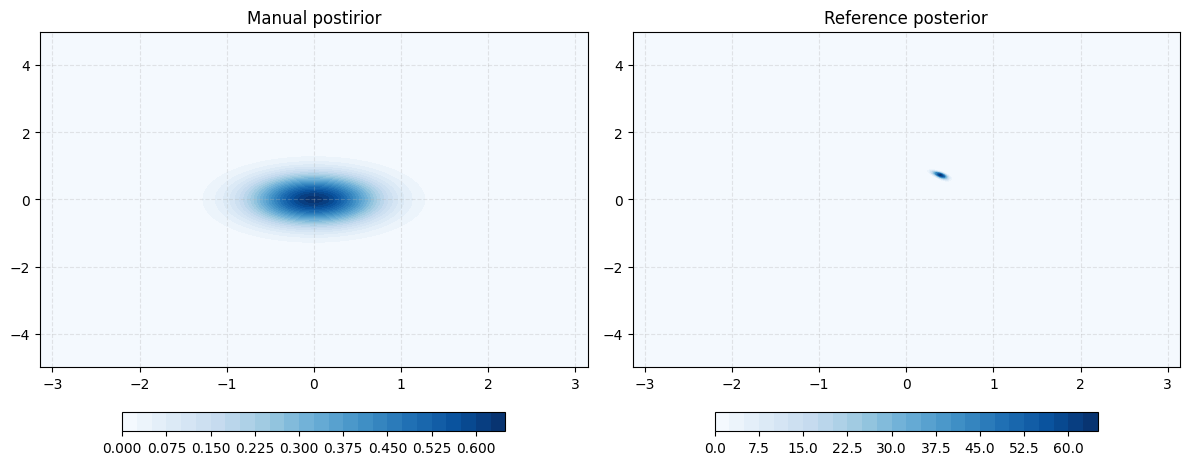


Max difference between grids: 6.30806e+01


In [4]:
print("\nRunning automated verification...")
automated_history = problem.run(initial_prior_grid)

# 2. Compare the Final Posteriors
#    We will plot your manual result vs the automated result side-by-side.
manual_final = manual_history[-1]['analysis']
auto_final = automated_history[-1]['analysis']
final_time = t_vals[-1]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Manual
_, c1 =  da.plot_grid_marginal(
            manual_final,
            dims=(0,1), 
            ax=axes[0], 
            cmap="Blues"
        )

# Plot Automated
_, c2 = da.plot_grid_marginal(
            auto_final, 
            dims=(0,1), 
            ax=axes[1],     
            cmap="Blues"
        )


titles = ["Manual postirior", "Reference posterior" ]
for ax, title, c in zip(axes, titles, [c1,c2]):
    ax.set_title(title)
    fig.colorbar(c, ax=ax, location="bottom", shrink=0.7, pad=0.1)

plt.tight_layout()
plt.show()

# Verification Check
diff = np.max(np.abs(manual_final.values - auto_final.values))
print(f"\nMax difference between grids: {diff:.5e}")
if diff < 1e-5:
    print("SUCCESS: Your manual implementation matches the reference!")
else:
    print("WARNING: Your implementation differs from the reference.")

## Part 2 - Reconstructing the dynamics

You can now estimate the posterior distribution at the final observation time. This PDFs could be pushed forward to any later time to arrive at a forecast. Here, however, we will focus on **reanalysis** of the dynamics. As discussed, this means pushing back the final posterior to the initial time to arrive at an 
update on the initial state. The posterior on the intiial state can then be used to reconstruct the systems complete dynamics over the observation period. 

Your first aim it to obtain and visualise the posterior PDF of the initial state. Having done this, you can then sample values from this distribution, and for each sample the corresponding trajectory. These sampled trajectories for both $\theta$ and $p$ should then be plotted as time series, with the $theta$ observations shown on the first plot.

In [ ]:
# We will now use the final posterior to learn about the past.
# You have the 'manual_final' grid from the end of your loop.
# You also have the final time 'final_time'.

print("\nRunning reanalysis...")

# --- TODO STEP 1: Obtain the Smoothed Initial Distribution ---
# 1. Take the final posterior grid ('manual_final')
# 2. Propagate it BACKWARDS in time to t=0 using the system dynamics.
#
# Hint: The method 'push_forward' takes a time step 'dt'. 
#       If you want to go back to the start, what should 'dt' be?

# --- SOLUTION ---

initial_postior_grid = None

# ----------------


# --- TODO STEP 2: Visualise the Improvement ---
# Plot the "Smoothed" initial grid against the original "Prior" grid 
# to see how much information we gained from the future observations.
#
# Hint: Use da.plot_grid_marginal just like in the verification step.

if initial_posterior_grid is not None:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot Prior
    da.plot_grid_marginal(initial_prior_grid, dims=(0,1), ax=axes[0], cmap="Blues")
    axes[0].set_title("Prior (t=0)")
    axes[0].plot(true_y0[0], true_y0[1], 'kx', label='Truth') # Add truth marker
    
    # Plot Reanalysis
    da.plot_grid_marginal(initial_posterior_grid, dims=(0,1), ax=axes[1], cmap="Blues")
    axes[1].set_title("Posterior (t=0)")
    axes[1].plot(true_y0[0], true_y0[1], 'kx', label='Truth')
    
    plt.tight_layout()
    plt.show()
    #pass


# --- TODO STEP 3: Reconstruct Trajectories ---
# Now we want to see the "bundle" of trajectories that are consistent with our data.
#
# 1. Sample points from your 'initial_posterior_grid'.
#    Hint: The ProbabilityGrid class has a .sample(n_samples) method.
#
# 2. For each sampled point, simulate the trajectory forward from t=0 to final_time.
#    Hint: Use da.solve_trajectory(eom_func, y0, t_eval).
#    Hint: You'll need an array of time points for t_eval (e.g. np.linspace(0, final_time, 100))
#
# 3. Plot these trajectories on top of the observations.
#    - Plot theta vs time in one subplot.
#    - Plot p (velocity) vs time in a second subplot.
#    - Use alpha=0.1 so the overlapping lines show the density of paths.

print("Sampling and reconstructing trajectories...")

# --- SOLUTION ---



# ----------------


Running reanalysis...
Sampling and reconstructing trajectories...
